<h1><span style="color:orange"></span> Stroke prediction - Classification task <span style="color:orange"></span>

In [46]:
import pandas as pd
import numpy as np

In [47]:
dataset = pd.read_csv('./data/healthcare-dataset-stroke-data.csv')

dataset.head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


<h1> Exploratory Data Analysis <span style="color:orange">

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import scipy.stats as stats 
from sklearn.preprocessing import StandardScaler, MinMaxScaler

<h3>Separate data by types

In [49]:
# First let's get the numerical features:
false_numericals = ['id', 'hypertension', 'heart_disease', 'stroke']  # get those features that came already onehot encoded but correspond to categorical variables (plus, id)
numerical = dataset.select_dtypes(exclude='object').drop(false_numericals, axis=1)

# Get the categorical variables:
categorical = dataset.select_dtypes(include='object')

<h3> Class Imbalance 

0    4861
1     249
Name: stroke, dtype: int64


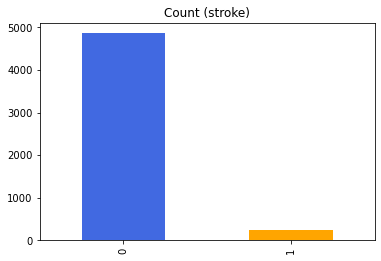

In [119]:
target_counts = dataset['stroke'].value_counts()
print(target_counts)
pd_plot = target_counts.plot.bar(title='Count (stroke)', color=['royalblue', 'orange'])


---> We clearly have a class imbalance problem we should work on.

<h3>Missing values

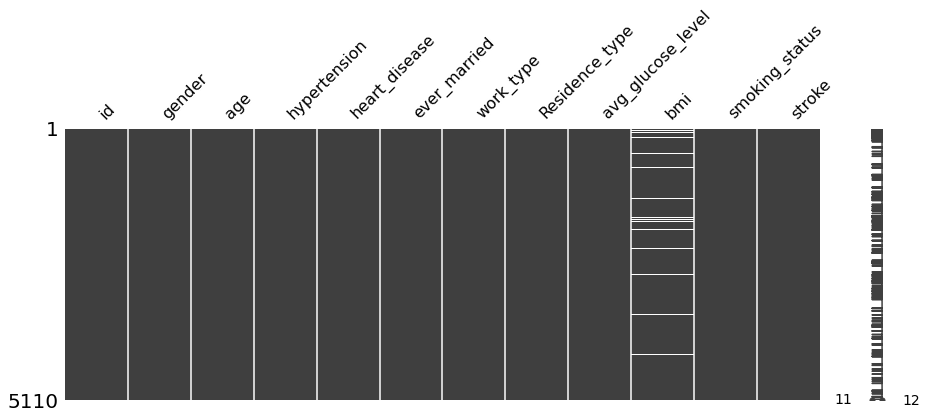

In [51]:
# Visualize the missing values:
msno.matrix(dataset, figsize=(15, 5))

In [52]:
# print number of rows for the dataset
print(f"{dataset.isnull().sum()['bmi']} missing values from a total of {dataset.shape[0]} ---> Not enough proportion to discard the feature.")

201 missing values from a total of 5110 ---> Not enough proportion to discard the feature.


<h3> Outliers

In [53]:
# Keep only the features to be explored for outliers (non categorical, non dummies, and not ids)
outliers_df = dataset.select_dtypes('number').drop(['id', 'hypertension', 'heart_disease', 'stroke'], axis=1)

outliers_df.head()

,age,avg_glucose_level,bmi
0,67.0,228.69,36.6
1,61.0,202.21,NaN
2,80.0,105.92,32.5
3,49.0,171.23,34.4
4,79.0,174.12,24.0


In [54]:
# gather all the IQRs for the features:
q1 = outliers_df.quantile(0.25)
q3 = outliers_df.quantile(0.75)
iqrs = q3 - q1

medians = outliers_df.median()

upper_thresholds = q3 + 1.5 * iqrs
lower_thresholds = q1 - 1.5 * iqrs

In [55]:
# Potentially getting rid of the outliers:
outliers_df = outliers_df[~((outliers_df < lower_thresholds) | (outliers_df > upper_thresholds))]

outliers_df.head()

,age,avg_glucose_level,bmi
0,67.0,NaN,36.6
1,61.0,NaN,NaN
2,80.0,105.92,32.5
3,49.0,NaN,34.4
4,79.0,NaN,24.0


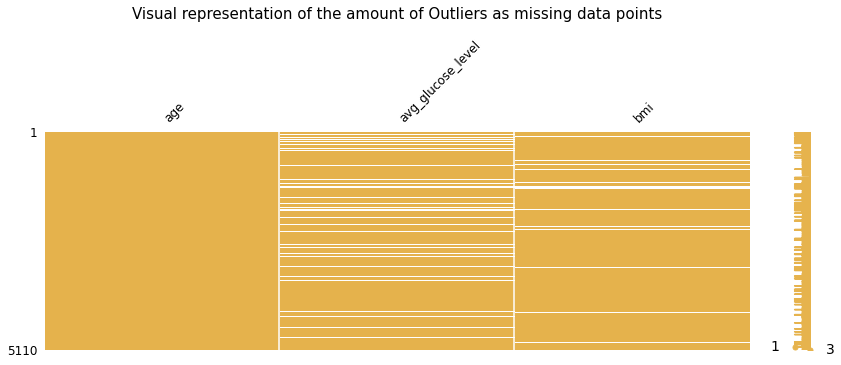

In [136]:
# let's visualize the new null values, as they will represent the outliers we have gotten rid off in our outliers_df (not in the original dataset, we are just exploring for now):
axe = msno.matrix(outliers_df, figsize=(14, 4), color=(0.9,0.7,0.3))  # orange: (1,0.65,0.23) golden: (0.81,0.71,0.23)
axe.set_title('Visual representation of the amount of Outliers as missing data points', fontsize=15, pad=20)
axe.tick_params(labelsize=12)

# This will help us have an idea of the proportion of outliers in the data.

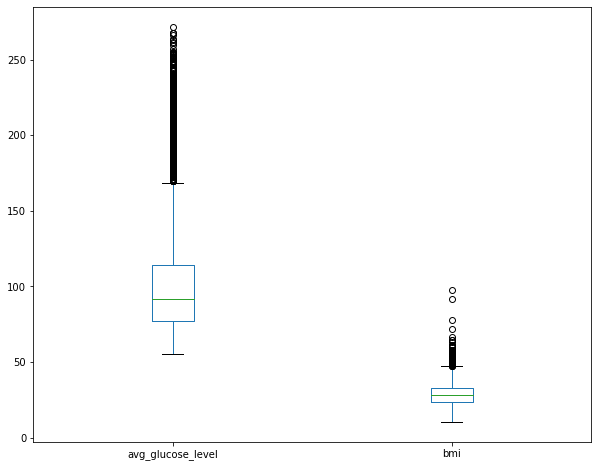

In [57]:
# We can also visualize the outliers through the use of boxlots:
dataset.boxplot(column=['avg_glucose_level', 'bmi'], figsize=(10, 8), grid=False);

# Again, as we can see there is seems to be a fairly high proportion of outliers in the data.

<p>What to do with the outliers:</p>
<ul>
  <li><b>avg_glucose_level's outliers</b> are probably so since they are likely subjects of diabetes or levels of glucose leading to a similar state. We can also tell since the proportion is large in the data, not quite what one would necessarily expect from the definition of an outlier. <u>Thus it is useful information and that we won't get rid of.</u></li>
  <br>
  <li>Similarly, <b>bmi's outliers</b> are probably representative of obesity (or the opposite) <u>Thus it is also useful information and that we won't get rid of.</u></li>
</ul>

<h3> Distribution of variables

C:\Users\lion9\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\lion9\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\lion9\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


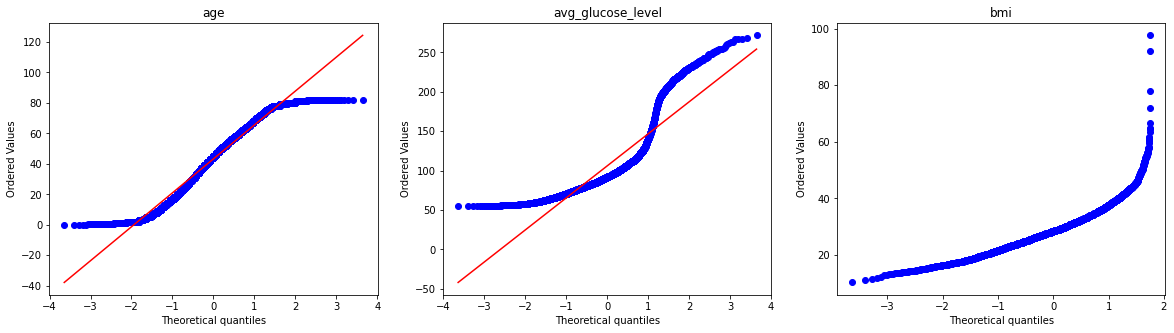

In [58]:
# Let's check the distributions of our numerical data:
number_of_plots = len(numerical.columns)
fig, axes = plt.subplots(1, number_of_plots, figsize=(20,5))

# We will use qqplots (quantile to quantile) to explore if the variables have normal distributions:
for i in range(number_of_plots):
        stats.probplot(numerical[numerical.columns[i]], dist='norm', plot=axes[i])
        axes[i].set_title(numerical.columns[i])

plt.show()

--> Non normal distributions

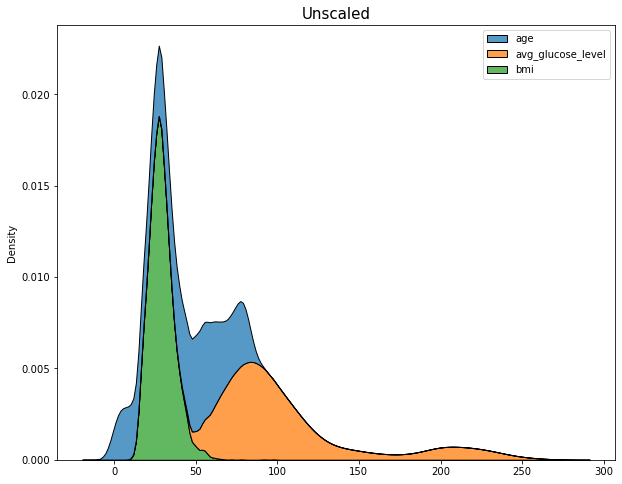

In [59]:
# Visualize the distributions for each numerical variable:
fig, axe = plt.subplots()
sns.kdeplot(data=numerical, multiple='stack')
axe.set_title('Unscaled', fontsize=15)
fig.set_size_inches(10,8)

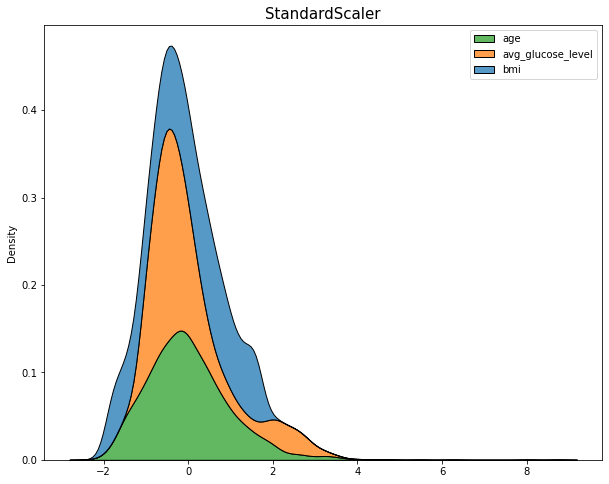

In [60]:
# Let's explore distributions with StandardScaler:
scaler = StandardScaler()
scaler.fit(numerical)
scaler_test_result = scaler.transform(numerical)
scaler_test_result = pd.DataFrame(scaler_test_result)

# Visualize distribution of variables after scaling:
fig, axe = plt.subplots()
sns.kdeplot(data=scaler_test_result, multiple='stack')
axe.set_title('StandardScaler', fontsize=15)
fig.set_size_inches(10,8)

# get the artists corresponding with the 3 data plots:
plots_list = axe.get_children()[0:3]

# Change the legend:
axe.legend([*plots_list], ['age', 'avg_glucose_level', 'bmi'])

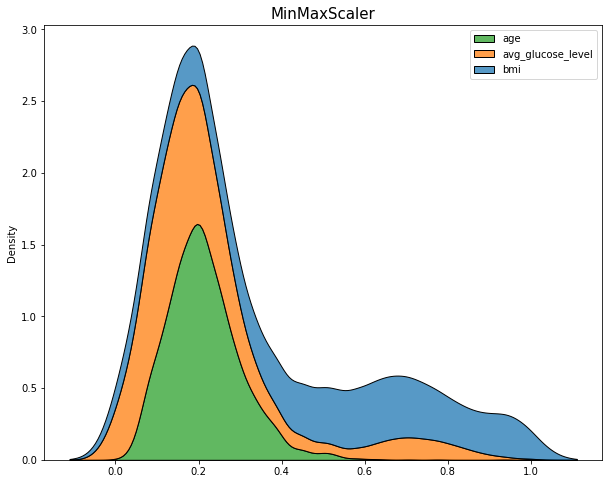

In [61]:
# Let's explore distributions with MinMaxScaler:
scaler = MinMaxScaler()
scaler.fit(numerical)
scaler_test_result = scaler.transform(numerical)
scaler_test_result = pd.DataFrame(scaler_test_result)

# Visualize distribution of variables after scaling:
fig, axe = plt.subplots()
sns.kdeplot(data=scaler_test_result, multiple='stack')
axe.set_title('MinMaxScaler', fontsize=15)
fig.set_size_inches(10,8)

# get the artists corresponding with the 3 data plots:
plots_list = axe.get_children()[0:3]

# Change the legend:
axe.legend([*plots_list], ['age', 'avg_glucose_level', 'bmi'])

<h1>Data Preprocessing <span style="color:orange">

<h2> <span style="color:">Handling class imbalance</span>

Dataset size before resampling: (5110, 12)
Dataset size after resampling: (1245, 12)


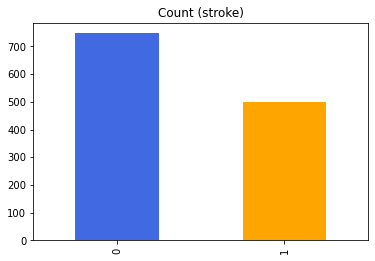

In [118]:
# Let's first try basic Random Under and Over sampling techniques:

# Get the value counts for each class:
class_0_count, class_1_count = dataset.stroke.value_counts()

# Separate data by class:
class_0 = dataset.loc[dataset['stroke'] == 0]
class_1 = dataset.loc[dataset['stroke'] == 1]

#Undersampling of majority class 0:
class_0_resampled = class_0.sample(class_1_count*3)  # Sampled at twice the amount of the lesser class  # TODO: try sampling at 3 times
# Oversampling of minority class 1:
class_1_resampled = class_1.sample(class_1_count*2, replace=True)  # Sampled at twice of the minority class
# Put them together and shuffle:
resampled_dataset = pd.concat([class_0_resampled, class_1_resampled], axis=0).sample(frac=1)

print("Dataset size before resampling:", dataset.shape)

print("Dataset size after resampling:", resampled_dataset.shape)

resampled_dataset.stroke.value_counts().plot.bar(title='Count (stroke)', color=['royalblue', 'orange'])

<h3> <span style="color:orange">Better class imbalance handling

In [63]:
import imblearn as rebalance

# Let's use more advanced ones from the library - imbalanced-learn:

<h3>Separate the data again, after resampling

In [64]:
# Get the numerical variables:
numerical = resampled_dataset.select_dtypes(exclude='object').drop(false_numericals, axis=1)

# Get the categorical variables:
categorical = resampled_dataset.select_dtypes(include='object')

<h2> Main data split

In [65]:
from sklearn.model_selection import train_test_split

In [66]:
x = resampled_dataset.drop('stroke', axis=1)
y = resampled_dataset['stroke']

# Leave a hold out (test) data split that is not going to be used in cross validation:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=resampled_dataset['stroke'])

x_train.shape

(996, 11)

<h2> Preprocessing pipeline

In [67]:
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix, classification_report, make_scorer
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Imputing model imports:
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

Preprocessing steps into our pipeline:
<ol>
<li>Feature Scaling for numerical features: MinMax Scaling</li>
<li>One hot encoding for categorical features: OneHotEncoder</li> 
<li>Put it all into ColumnTranformer.</li>
<li>Missing values imputation for bmi: Decision Tree Regression</li> 
</ol>

<h3><h3><span style="color:yellow"></span> DecisionTreeRegressor to impute the missing values for bmi<span style="color:red"></span>

In [68]:

# Pipelines in case we want to add new steps to each data subset:
# num_pipeline = Pipeline([
#     ('scaler', MinMaxScaler()),
# ])

# cat_pipeline = Pipeline([
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))

# ])


class Debug(BaseEstimator, TransformerMixin):

    def transform(self, X):
        self.df_x = pd.DataFrame(X)
        self.shape = X.shape
        self.null_columns = self.df_x.isnull().sum().to_frame().T
        # what other output you want
        # print(df_x.head())
        return X

    def fit(self, X, y=None, **fit_params):
        return self


# Use a ColumnTransformer to do transformations on different categorical and numerical types separately:
preprocessing_ct = ColumnTransformer(
    transformers=[
        ('minmax', MinMaxScaler(), numerical.columns.tolist()),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical.columns.tolist())
    ],
        remainder='passthrough',
    )


# Get the ColumnTransformer into the final imputation pipeline:
model_imputation_pipeline = Pipeline([
        ('preprocessing_ct', preprocessing_ct),
        ("debug", Debug()),
        ('imputation', IterativeImputer(DecisionTreeRegressor())),
    ])


model_imputation_pipeline

Pipeline(steps=[('preprocessing_ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('minmax', MinMaxScaler(),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'ever_married',
                                                   'work_type',
                                                   'Residence_type',
                                                   'smoking_status'])])),
                ('debug', Debug()),
                ('imputation',
                 IterativeImputer(estimator=DecisionTreeRegressor()))])

In [69]:
# Sample imputation for testing performance:
x_train_sample, x_test_sample, _, _ = train_test_split(x_train, y_train, test_size=0.2)

model_imputation_pipeline.fit(x_train_sample)

imputed_sample = pd.DataFrame(model_imputation_pipeline.transform(x_train_sample))

# Allow to print the full width of the dataframe for clarity:
pd.set_option('display.width', 500)
pd.set_option('max_columns', 25)

print("\nThanks to a debbuging step in the pipeline, we can see the number of missing values on each column, and thus confirm that number 2 is corresponding to bmi:\n\n", model_imputation_pipeline.named_steps['debug'].null_columns)
print("\nFinally, after imputation:\n\n", imputed_sample.isnull().sum().to_frame().T)


Thanks to a debbuging step in the pipeline, we can see the number of missing values on each column, and thus confirm that number 2 is corresponding to bmi:

    0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  18  19  20
0   0   0  65   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

Finally, after imputation:

    0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  18  19  20
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0


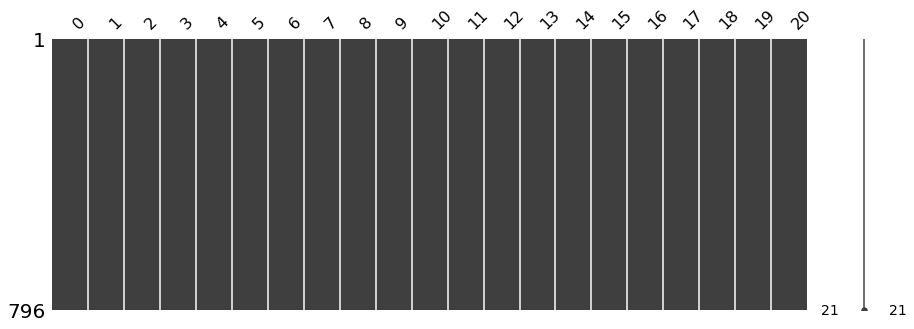

In [70]:
# Visualization of missing values after imputation:
msno.matrix(imputed_sample, figsize=(15, 5));

<h1> Feature and Model selection <span style="color:orange">

In [71]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from pprint import pprint

<h2> Trees<span style="color:yellow"></span>

** Remember decision Trees are embedded methods for feature selection, meaning feature selection is performed as they are fitted.


<h3>DecisionTreeClassifier


Best hyperparameters: {'classifier__max_depth': 25, 'classifier__max_features': 11, 'classifier__min_samples_split': 3} 

Best score (precision): 0.7684759342132729 

              precision    recall  f1-score   support

           0       0.93      0.85      0.89       149
           1       0.81      0.91      0.85       100

    accuracy                           0.88       249
   macro avg       0.87      0.88      0.87       249
weighted avg       0.88      0.88      0.88       249



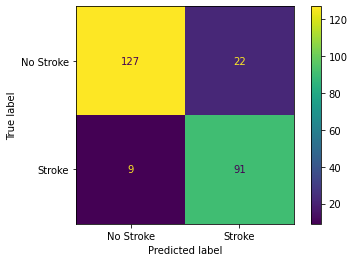

In [72]:

# Create a pipeline for our preprocessing and model steps:
pipeline = Pipeline([
    ('model_imputation_pipeline', model_imputation_pipeline), 
    ('classifier', DecisionTreeClassifier())  # We try to avoid applying preprocessing steps outside of the pipeline to avoid data leakage.
])  


# Now we will use gridsearch to choose the best hyperparams and pass the pipeline to it (it will handle the crossvalidation as well):

param_grid = {
    'classifier__min_samples_split':[3, 5, 10],
    'classifier__max_depth': [3, 5, 15, 25],
    'classifier__max_features': [3, 5, 11, 20],
}

scores = {
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'accuracy': make_scorer(accuracy_score),
}

grid = GridSearchCV(pipeline, param_grid=param_grid, scoring=scores, refit='precision', cv=8, return_train_score=True)  # We change the performance metric on 'refit' so that the predictions don't match the underlying dristribution (due to class imbalance)

grid.fit(x_train, y_train)

print("\nBest hyperparameters:", grid.best_params_, "\n")
print("Best score (precision):", grid.best_score_, "\n")

preds = grid.predict(x_test)

plot_confusion_matrix(grid, x_test, y_test, display_labels=['No Stroke', 'Stroke'])

print(classification_report(y_test, preds)) 

<h3>RandomForestClassifier

              precision    recall  f1-score   support

           0       0.93      0.85      0.88       149
           1       0.80      0.90      0.85       100

    accuracy                           0.87       249
   macro avg       0.86      0.87      0.86       249
weighted avg       0.87      0.87      0.87       249



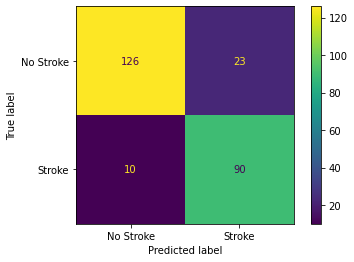

In [73]:
pipeline = Pipeline([
    ('model_imputation_pipeline', model_imputation_pipeline), 
    ('classifier', RandomForestClassifier())
]) 

pipeline.fit(x_train, y_train)
preds = pipeline.predict(x_test)

# maybe add gridsearch for parameters

plot_confusion_matrix(pipeline, x_test, y_test, display_labels=['No Stroke', 'Stroke'])

print(classification_report(y_test, preds))

<h3>XGBoostClassifier

              precision    recall  f1-score   support

           0       0.93      0.86      0.89       149
           1       0.81      0.90      0.85       100

    accuracy                           0.88       249
   macro avg       0.87      0.88      0.87       249
weighted avg       0.88      0.88      0.88       249



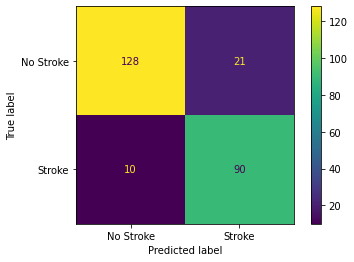

In [74]:
pipeline = Pipeline([
    ('model_imputation_pipeline', model_imputation_pipeline), 
    ('classifier', XGBClassifier())
]) 

pipeline.fit(x_train, y_train)
preds = pipeline.predict(x_test)

plot_confusion_matrix(pipeline, x_test, y_test, display_labels=['No Stroke', 'Stroke'])

print(classification_report(y_test, preds))

<h2> Naive Bayes Classifier

Feature selection with wrapper method Recursive Feature Elimination (naive bayes is not a embedded method for feature selection).

Best score (pipeline.score): 0.7469879518072289 

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.84      0.71      0.77       149\n'
 '           1       0.65      0.80      0.72       100\n'
 '\n'
 '    accuracy                           0.75       249\n'
 '   macro avg       0.75      0.76      0.74       249\n'
 'weighted avg       0.76      0.75      0.75       249\n')


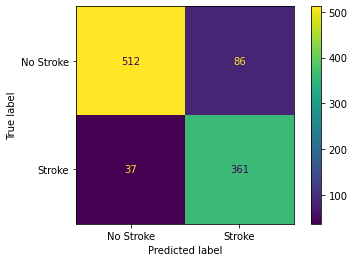

In [75]:
selector = RFECV(estimator=CategoricalNB(), scoring=make_scorer(precision_score), cv=8)

nb = CategoricalNB()

# Perform hyperparameter tunning (for our feature selector - RFE)
pipeline =  make_pipeline(model_imputation_pipeline, nb)

pipeline.fit(x_train, y_train)
preds = pipeline.predict(x_test)

print("Best score (pipeline.score):", pipeline.score(x_test, y_test), "\n")

plot_confusion_matrix(pipeline, x_train, y_train, display_labels=['No Stroke', 'Stroke'])

pprint(classification_report(y_test, preds))

In [76]:
# Perform grid search to tune RFE's number of features to select:

# params = {'rfe__n_features_to_select': list(range(6,21))}

# scores = {
#     'precision': make_scorer(precision_score),
#     'recall': make_scorer(recall_score),
#     'accuracy': make_scorer(accuracy_score),
# }

# grid = GridSearchCV(estimator=pipeline, param_grid=params, scoring='precision', cv=8, refit=True, return_train_score=True)

# grid.fit(x_train, y_train)
# preds = grid.predict(x_test)

# print("Best hyperparameters:", grid.best_params_, "\n")
# print("Best score (precision):", grid.best_score_, "\n")
# print("Best score (grid.score:", grid.score(x_test, y_test), "\n")

<h2>K-Nearest Neighbors

Accuracy: 0.7076305220883534
Precision: 0.6744791666666666
Recall: 0.5200803212851406
F1 score: 0.5873015873015872
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.72      0.83      0.77       747\n'
 '           1       0.67      0.52      0.59       498\n'
 '\n'
 '    accuracy                           0.71      1245\n'
 '   macro avg       0.70      0.68      0.68      1245\n'
 'weighted avg       0.70      0.71      0.70      1245\n')


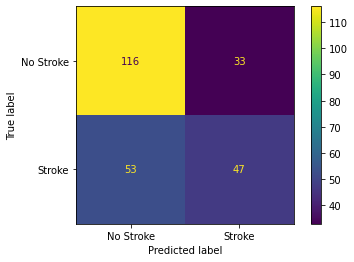

In [77]:

pipeline = make_pipeline(model_imputation_pipeline, KNeighborsClassifier(n_neighbors=10))

# In KNN there is **no training (we use the whole dataset)** step because there is no model to build, template matching and interpolation is all that is happening.
pipeline.fit(x, y)

preds = pipeline.predict(x)

print("Accuracy:", pipeline.score(x, y))
print("Precision:", precision_score(y, preds))
print("Recall:", recall_score(y, preds))
print("F1 score:", f1_score(y, preds))

plot_confusion_matrix(pipeline, x_test, y_test, display_labels=['No Stroke', 'Stroke'])

pprint(classification_report(y, preds))

<h2>Support Vector Machines

Accuracy: 0.5983935742971888
Precision: 0.0
Recall: 0.0
F1 score: 0.0
('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.60      1.00      0.75       149\n'
 '           1       0.00      0.00      0.00       100\n'
 '\n'
 '    accuracy                           0.60       249\n'
 '   macro avg       0.30      0.50      0.37       249\n'
 'weighted avg       0.36      0.60      0.45       249\n')
C:\Users\lion9\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lion9\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter

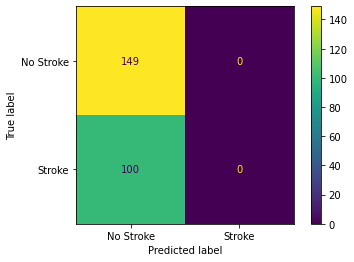

In [78]:

pipeline = make_pipeline(model_imputation_pipeline, SVC())
pipeline.fit(x_train, y_train)

preds = pipeline.predict(x_test)

print("Accuracy:", pipeline.score(x_test, y_test))
print("Precision:", precision_score(y_test, preds))
print("Recall:", recall_score(y_test, preds))
print("F1 score:", f1_score(y_test, preds))

plot_confusion_matrix(pipeline, x_test, y_test, display_labels=['No Stroke', 'Stroke'])

pprint(classification_report(y_test, preds))